## Hillslope diffusion model for Eightmile Lake

### Inputs: Eightmile Lake DEM
### Components: ExponentialWeatherer, DepthDependentDiffuser
### Outputs: Soil flux map

In [54]:
import numpy as np
import matplotlib.pyplot as plt

import rasterio as rio
from rasterio.enums import Resampling

from landlab import RasterModelGrid
from landlab.plot import imshow_grid
from landlab.io import read_esri_ascii
from landlab.components import ExponentialWeatherer, DepthDependentDiffuser

### Step 1) Resample DEM to 30m

In [11]:
current = 2 # meters per pixel
target = 30 # meters per pixel
scale = current / target

with rio.open('./gis/projects/dem/eightmile-lake-watershed-dem-filled.tif') as src:

    # resample data to target shape
    data = src.read(
        out_shape = (
            src.count,
            int(src.height * scale),
            int(src.width * scale)
        ),
        resampling = Resampling.bilinear
    )

    # scale image transform
    transform = src.transform * src.transform.scale(
        (src.width / data.shape[-1]),
        (src.height / data.shape[-2])
    )
    
dem = data[0]

In [12]:
print(dem.shape)

(836, 1192)


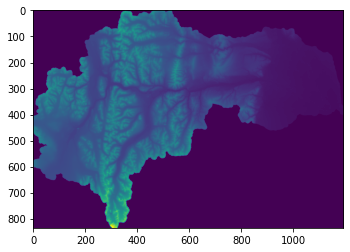

In [13]:
plt.imshow(dem)
plt.show()

### Step 2) Set up model grid and initial conditions

In [20]:
grid = RasterModelGrid((dem.shape[0], dem.shape[1]), target)

In [48]:
grid.add_field('topographic__elevation', np.flip(dem, 0), at = 'node', units = 'm', copy = True, clobber = True)

array([ 0.,  0.,  0., ...,  0.,  0.,  0.], dtype=float32)

In [25]:
grid.set_nodata_nodes_to_closed(grid.at_node['topographic__elevation'], 0)

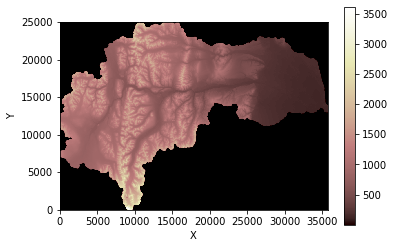

In [26]:
imshow_grid(grid, grid.at_node['topographic__elevation'])

In [49]:
initial_soil = 1 # meters
grid.add_field('bedrock__elevation', np.flip(dem) - initial_soil, at = 'node', clobber = True)
grid.add_zeros('soil__depth', at = 'node', clobber = True)
grid.at_node['soil__depth'] = grid.at_node['topographic__elevation'] - grid.at_node['bedrock__elevation']

### Step 3) Initialize model components

In [58]:
# Convert fields from float32 to float
# TODO ask Mark what's going on with the components here

grid.at_node['topographic__elevation'] = grid.at_node['topographic__elevation'].astype(float)
grid.at_node['bedrock__elevation'] = grid.at_node['bedrock__elevation'].astype(float)
grid.at_node['soil__depth'] = grid.at_node['soil__depth'].astype(float)

In [59]:
EW = ExponentialWeatherer(grid)
DD = DepthDependentDiffuser(grid)

In [ ]:
nt = 100 # years
dt = 1 # year

for i in range(nt):
    EW.calc_soil_prod_rate()
    DD.run_one_step(dt)

### Step 4) Visualize results

/home/egp/.virtualenvs/landlab/lib/python3.9/site-packages/landlab/grid/raster_mappers.py:638: RuntimeWarning: overflow encountered in add
  values_at_links[north]
/home/egp/.virtualenvs/landlab/lib/python3.9/site-packages/landlab/grid/raster_mappers.py:638: RuntimeWarning: invalid value encountered in add
  values_at_links[north]
/home/egp/.virtualenvs/landlab/lib/python3.9/site-packages/matplotlib/colors.py:1254: RuntimeWarning: overflow encountered in true_divide
  resdat /= (vmax - vmin)
/home/egp/.virtualenvs/landlab/lib/python3.9/site-packages/matplotlib/colors.py:621: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


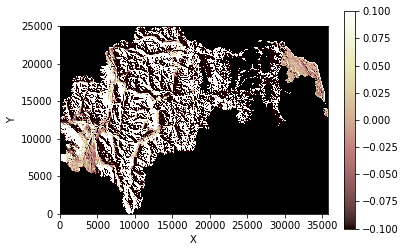

In [66]:
from landlab.grid.raster_mappers import map_mean_of_links_to_node
flux_at_nodes = map_mean_of_links_to_node(grid, 'soil__flux')
imshow_grid(grid, flux_at_nodes)